In [25]:
import numpy as np
import qiskit as q
from qiskit import QuantumCircuit, transpile, assemble, Aer, IBMQ, QuantumRegister, AncillaRegister
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import Statevector
from qiskit.visualization import array_to_latex
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
import matplotlib.cm as cm
import qiskit.circuit.library as qlib
%matplotlib inline
from qiskit import transpile

In [26]:
#both parameters

M = 16 # lattices
rows = 16
cols = 16
dim = 2
dirs = 5
nlat = int(np.ceil(np.log2(M)))
nlinks = int(np.ceil(np.log2(dirs)))

In [27]:
vort= np.zeros((M,M))
VO=np.ones((M,M))
stream= np.zeros((M,M))
gradient_1d = np.linspace(0,1,cols) 
dd = np.zeros((M,M))
temp = np.ones((M,M))
T = np.tile(gradient_1d, (rows, 1))
T = np.flip(T, axis=1)
dt=1.
Pr = 0.71
Ra = 10000
Re=np.sqrt(Ra/Pr)
U = 0.1
cs2 = 1/3  
cf =U*U
cvis=U*(M-1)/Re
cdif=cvis/Pr
e = (0,1,-1,1,-1)
tau = cvis/cs2/dt + 0.5
taut = cdif/cs2/dt + 0.5
wts = (2/6,1/6,1/6,1/6,1/6)
lambdas = [np.arccos(i) for i in wts]

In [28]:

def top_half(A):
    def convert(val):
        return val+1j*np.sqrt(1-val**2)
    func = np.vectorize(convert)
    return func(A)
def bottom_half(A):
    def convert(val):
        return val-1j*np.sqrt(1-val**2)
    func = np.vectorize(convert)
    return func(A)

In [29]:

def createLambda(oper, isC1 = True):
    ctrl = oper
    if oper >= 8:
        oper -= 8
    s = bin(ctrl)[2:]
    s = '0'*int((4-len(s))) + s
    nlambda = lambdas[oper]
    
    if not isC1:
        nlambda*=-1

    qc = QuantumCircuit(2+nlinks)
    tmp = QuantumCircuit(1)

    tmp.p(nlambda, 0)
    tmp.x(0)
    tmp.p(nlambda, 0)
    tmp.x(0)
    gate = tmp.to_gate(label = "Lambda"+str(ctrl)).control(nlinks+1,ctrl_state = s)
    cbits = [i for i in range(1,nlinks+2)]
    cbits.append(0)
    qc.append(gate,cbits)
    return qc

In [30]:

def rshift(n):
    circ = QuantumCircuit(n)
    for i in range(n):
        if i == n-1:
            circ.x(i)
        else:
            circ.mcx(list(range(i+1,n)), i)
    return circ
def lshift(n):
    circ = QuantumCircuit(n)
    for i in reversed(range(n)):
        if i == n-1:
            circ.x(i)
        else:
            circ.mcx(list(range(i+1,n)), i)
    return circ

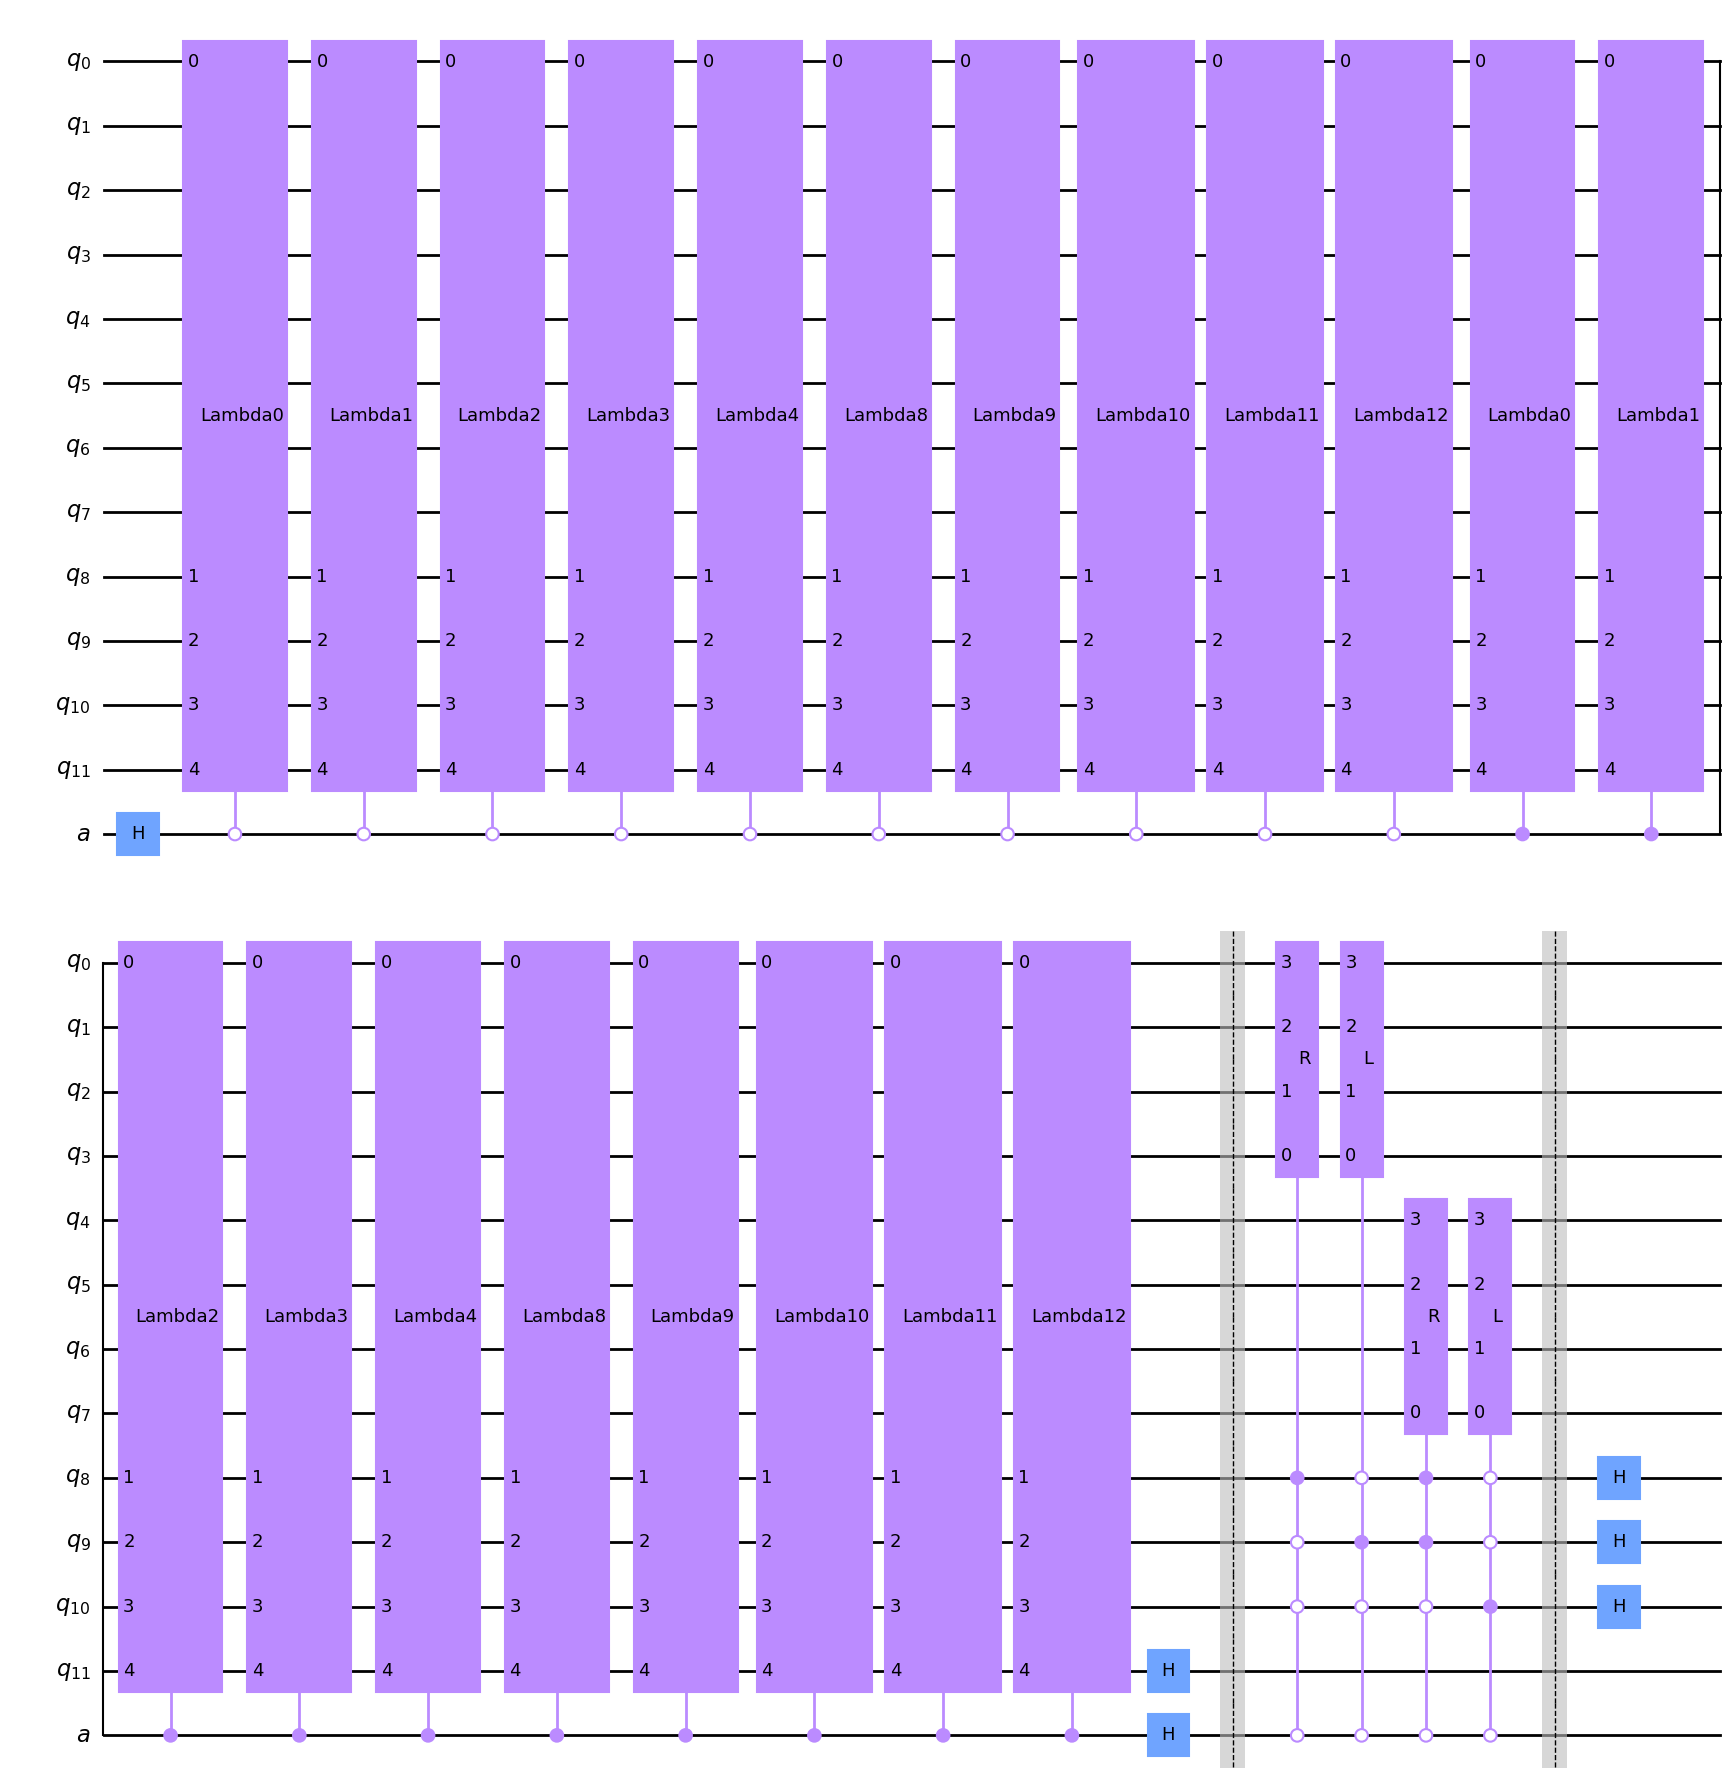

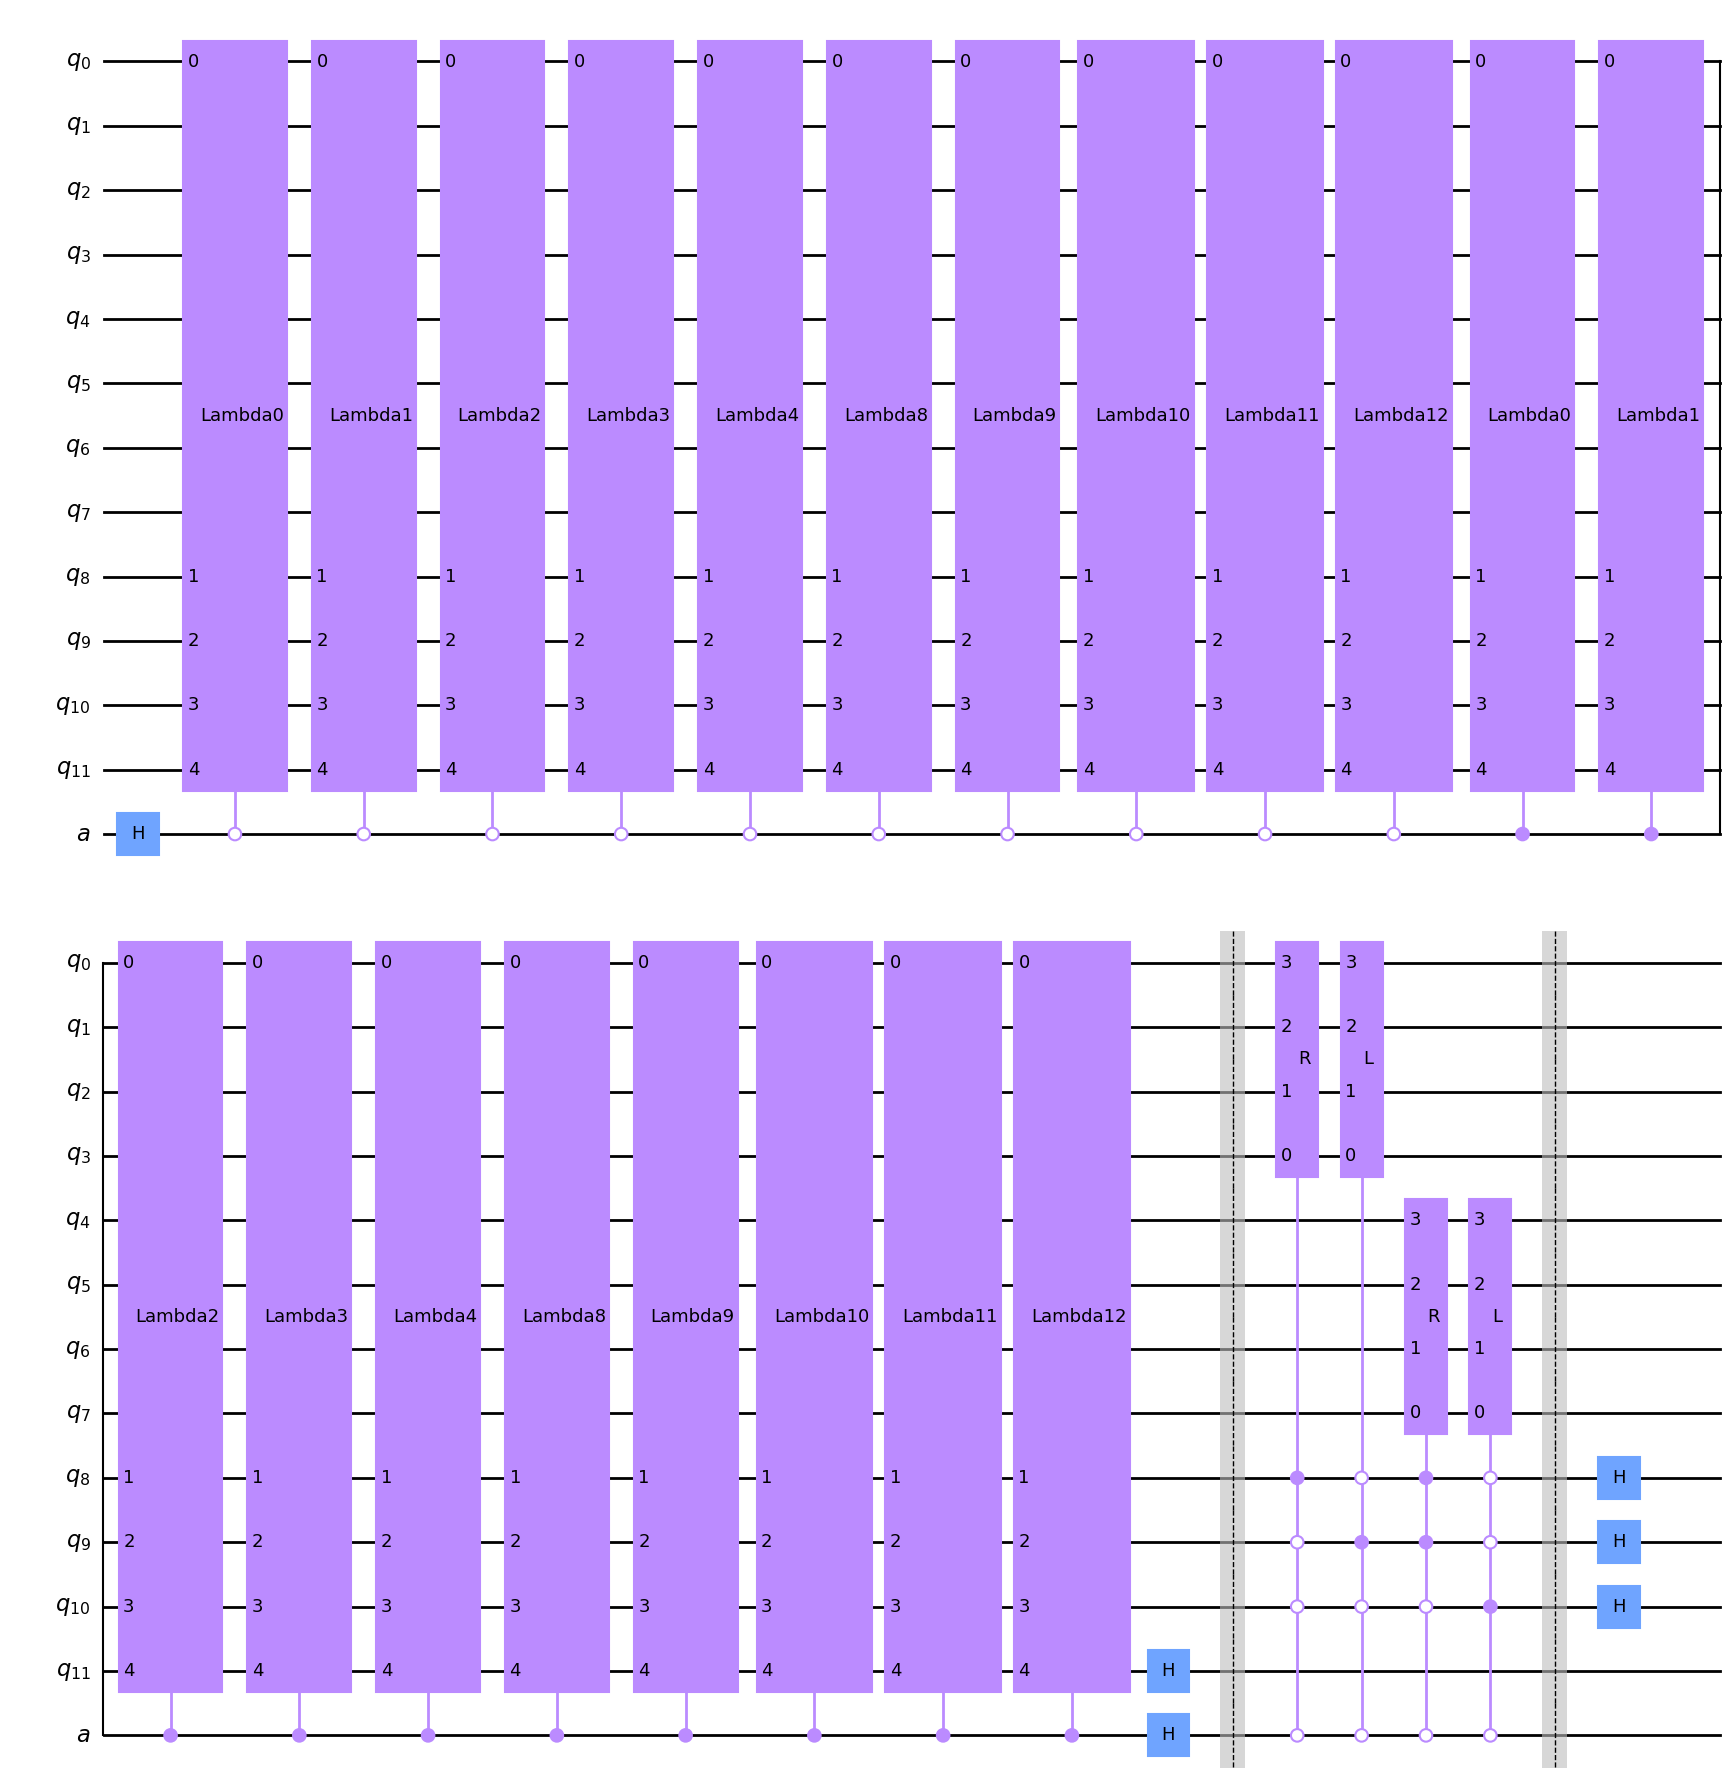

In [31]:
def streamCirc():
    q = QuantumRegister(nlinks+dim*nlat+1,'q')
    a = AncillaRegister(1,'a')

    setup = QuantumCircuit(q)
    setup.add_register(a)

    h1 = qlib.HGate().control(1,ctrl_state = 0)

    cb = [a,0]
    cb.extend([i for i in range(dim*nlat, dim*nlat+nlinks+1)])
    setup.h(a)
    for i in range(dirs):
        setup.append(createLambda(i,True).to_gate(label = 'Lambda'+str(i)).control(1,ctrl_state = 0),cb)
    for i in range(8,13):
        setup.append(createLambda(i,True).to_gate(label = 'Lambda'+str(i)).control(1,ctrl_state = 0),cb)
    for i in range(dirs):
        setup.append(createLambda(i,False).to_gate(label = 'Lambda'+str(i)).control(1,ctrl_state = 1),cb)
    for i in range(8,13):
        setup.append(createLambda(i,False).to_gate(label = 'Lambda'+str(i)).control(1,ctrl_state = 1),cb)
    setup.h(q[11])
    setup.h(a)
    
    setup.barrier()
    R1 = rshift(nlat).to_gate(label = "R").control(nlinks+1,ctrl_state = '0001')
    L1 = lshift(nlat).to_gate(label = "L").control(nlinks+1,ctrl_state = '0010')
    R2 = rshift(nlat).to_gate(label = "R").control(nlinks+1,ctrl_state = '0011')
    L2 = lshift(nlat).to_gate(label = "L").control(nlinks+1,ctrl_state = '0100')
    setup.append(R1,[8,9,10,a[0],3,2,1,0])
    setup.append(L1,[8,9,10,a[0],3,2,1,0])
    setup.append(R2,[8,9,10,a[0],7,6,5,4])
    setup.append(L2,[8,9,10,a[0],7,6,5,4])
    setup.barrier()


    setup.h(8)
    setup.h(9)
    setup.h(10)
    
    return setup
streamCirc().draw()

In [32]:
def uv(stream):
    u = stream[1:,:]-stream[:-1,:]
    v = (stream[:,1:]-stream[:,:-1])

    v = np.append(v,np.reshape(v[:,-1],(M,1)),axis=1)
    u = np.append(u,u[-1:],axis=0)

    v*=-1

    return u, v   
def TT(T):
    dTdx = (T[:,1:] -T[:,:-1])/dt
    dTdy = (T[1:,:] -T[:-1,:])/dt  

    dTdy[0]   =0     
    dTdy[-1]   = 0

    dTdx[:,0] = (T[:,1]-1)/dt
    dTdx[:,-1] = - T[:,-2]/dt  

    dTdx = np.append(dTdx,np.reshape(dTdx[:,-1],(M,1)),axis=1)
    dTdy = np.append(dTdy,dTdy[-1:],axis=0)

    return dTdx,dTdy

def F(dTdx):
    
    force=U*U*dTdx
    
    return force
def collision_f(u,v): 
    ex = (0,1,-1,0,0) 
    ey = (0,0,0,1,-1) 


    dudx = (u[1:-1,2:] - u[1:-1, :-2])/2
    dudy = (u[2:,1:-1] - u[:-2, 1:-1])/2
    dvdx = (v[1:-1,2:] - v[1:-1, :-2])/2
    dvdy = (v[2:,1:-1] - v[:-2, 1:-1])/2

    dudx = np.pad(dudx , ((1, 1), (1, 1)), mode='edge')  
    dudy = np.pad(dudy, ((1, 1), (1, 1)), mode='edge')  
    dvdx = np.pad(dvdx, ((1, 1), (1, 1)), mode='edge')  
    dvdy = np.pad(dvdy, ((1, 1), (1, 1)), mode='edge')  
    vorts= np.zeros((5, M, M))  

    feq = np.zeros((5, M, M))  

    for link in range(5):     
        feq[link] = wts[link]*vort*(1+(ex[link]*u+ey[link]*v)/cs2)
        vorts[link] = feq[link]*(1 - (tau-1)*dt /cs2*((ex[link]-u)*((ex[link]-u)*dudx+(ey[link]-v)*dudy)+(ey[link]-v)*((ex[link]-u)*dvdx+(ey[link]-v)*dvdy)))  

    return vorts.flatten()  


In [33]:
def collision_T(T,Tm,u,v,dTdx,dTdy): 
    teq = np.zeros((5, M, M))
   
    dudx = (u[:,1:] +(-1.)*u[:,:-1])
    dudy = (u[1:,:] +(-1.)*u[:-1,:])
    dvdx = (v[:,1:] +(-1.)*v[:,:-1])
    dvdy = (v[1:,:] +(-1.)*v[:-1,:])
    dvdx = np.append(dvdx,np.reshape(dvdx[:,-1],(M,1)),axis=1)
    dudx = np.append(dudx,np.reshape(dudx[:,-1],(M,1)),axis=1)
    dvdy = np.append(dvdy,dvdy[-1:],axis=0)
    dudy = np.append(dudy,dudy[-1:],axis=0)
    dvdy[0] =v[1]/dt     
    dudy[0] =u[1]/dt     
    dvdy[-1] = (0 -v[-2])/dt 
    dudy[-1] = (0 -u[-2])/dt

    dvdx[:,0] =v[:,1]/dt
    dudx[:,0] =u[:,1]/dt
    dvdx[:,-1] =(0-v[:,-2])/dt
    dudx[:,-1] =(0-u[:,-2])/dt

    ex = (0,1,-1,0,0) 
    ey = (0,0,0,1,-1) 
    wts = (2/6,1/6,1/6,1/6,1/6)
    
    fneq = np.zeros((5, M, M)) 
    feq = np.zeros((5, M, M))
    teq = np.zeros((5, M, M))    
    for link in range(5):     
        feq[link] = wts[link]*(T-Tm)*(1+(ex[link]*u+ey[link]*v)/cs2)
        teq[link] = feq[link]*(1 - (taut-1)*dt /cs2*(((ex[link]-u)*dTdx+(ey[link]-v)*dTdy)*cs2))  
    
    return teq.flatten()

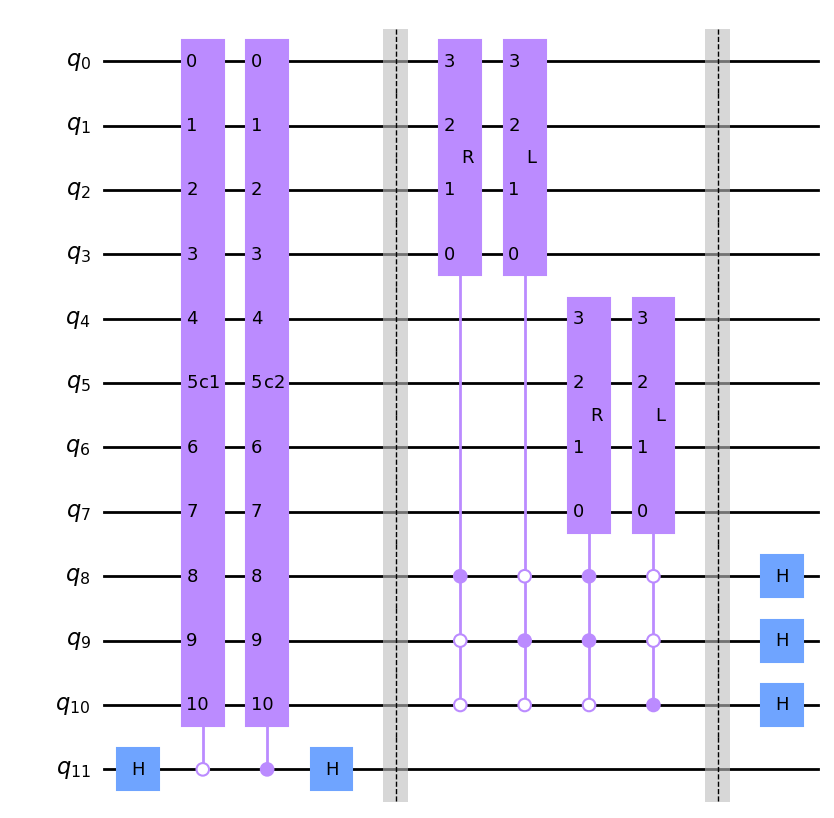

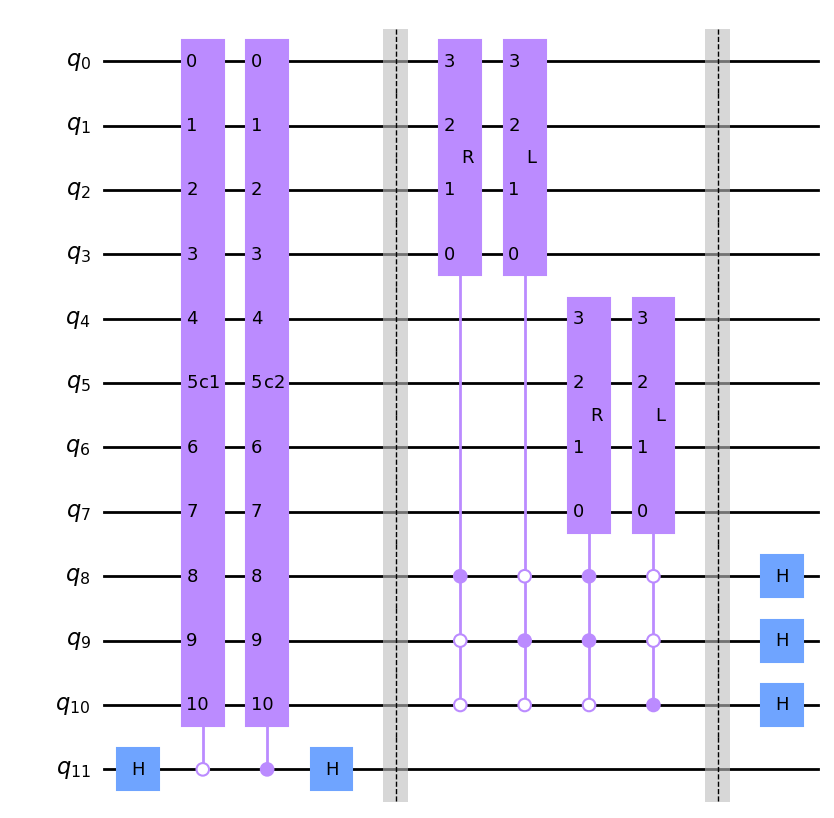

In [34]:
def vortCirc(vort,stream):
    q = QuantumRegister(nlinks+dim*nlat+1,'q')

    setup = QuantumCircuit(q)
    
    h1 = qlib.HGate().control(1,ctrl_state = 0)
    h3 = qlib.HGate().control(2,ctrl_state = '00')
    
    u, v = uv(stream)
   
    A_diag = collision_f(u,v)
    
    
    zeros = np.zeros(M*M)
    A_diag = np.concatenate((A_diag, np.zeros(2**11 - A_diag.size)))
    B1_diag = top_half(A_diag)
    B2_diag = bottom_half(A_diag)
    
    setup.h(11)
    
    Col1 = QuantumCircuit(QuantumRegister(11))
    Col1.diagonal(list(B1_diag),qubit = [0,1,2,3,4,5,6,7,8,9,10])
    Col1 = Col1.to_gate(label='c1')
    
    Col2 = QuantumCircuit(QuantumRegister(11))
    Col2.diagonal(list(B2_diag),qubit = [0,1,2,3,4,5,6,7,8,9,10])
    Col2 = Col2.to_gate(label='c2')
    
    setup.append(Col1.control(1,ctrl_state = '0'),[11,0,1,2,3,4,5,6,7,8,9,10])
    setup.append(Col2.control(1,ctrl_state = '1'),[11,0,1,2,3,4,5,6,7,8,9,10])

    setup.h(11)



    setup.barrier()
    R1 = rshift(nlat).to_gate(label = "R").control(nlinks,ctrl_state = '001')
    L1 = lshift(nlat).to_gate(label = "L").control(nlinks,ctrl_state = '010')
    R2 = rshift(nlat).to_gate(label = "R").control(nlinks,ctrl_state = '011')
    L2 = lshift(nlat).to_gate(label = "L").control(nlinks,ctrl_state = '100')
    setup.append(R1,[8,9,10,3,2,1,0])
    setup.append(L1,[8,9,10,3,2,1,0])
    setup.append(R2,[8,9,10,7,6,5,4])
    setup.append(L2,[8,9,10,7,6,5,4])
    setup.barrier()


    setup.h(8)
    setup.h(9)
    setup.h(10)

    return setup

vortCirc(vort,stream).draw()

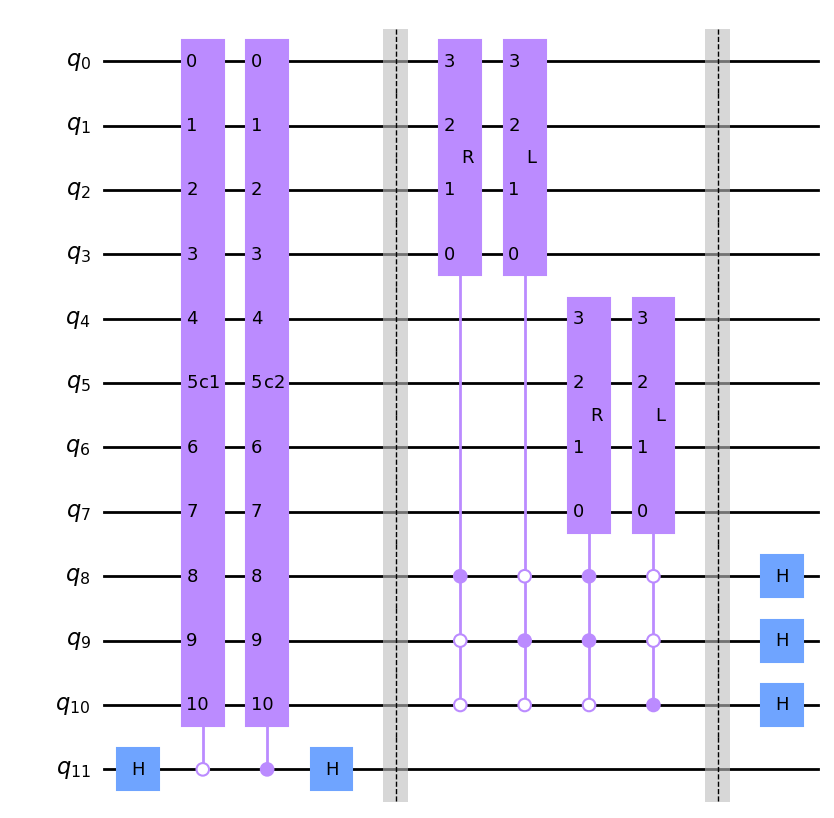

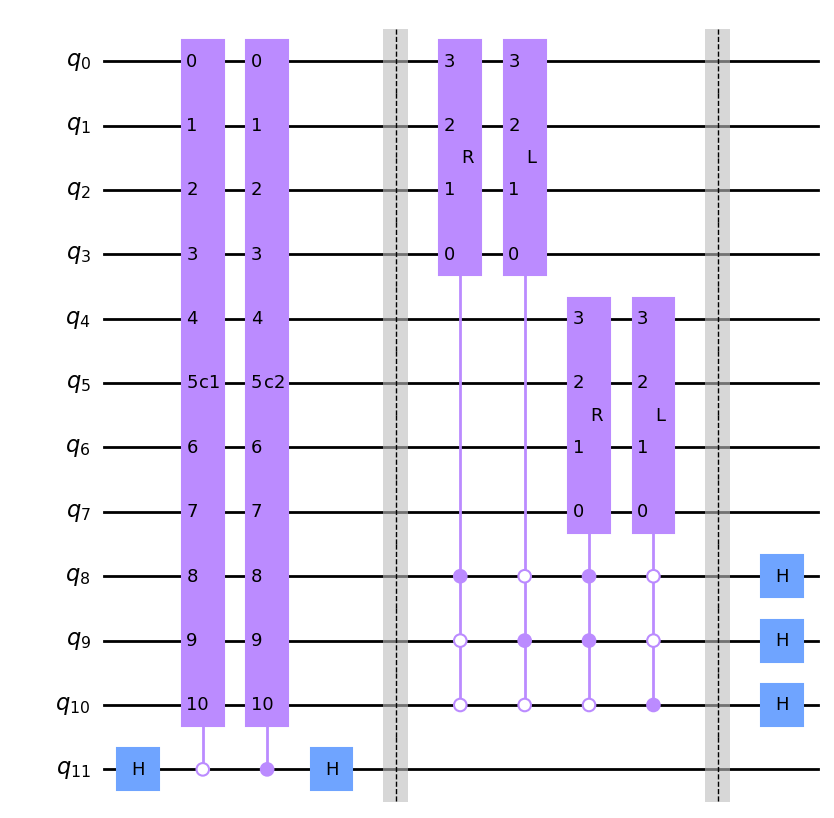

In [35]:
def tCirc(T,Tm,stream,dTdx,dTdy):
    q = QuantumRegister(nlinks+dim*nlat+1,'q')

    setup = QuantumCircuit(q)
    
    h1 = qlib.HGate().control(1,ctrl_state = 0)
    h3 = qlib.HGate().control(2,ctrl_state = '00')
    
    u, v = uv(stream)
 
    A_diag = collision_T(T,Tm,u, v,dTdx,dTdy)
    
    
    zeros = np.zeros(M*M)
    A_diag = np.concatenate((A_diag, np.zeros(2**11 - A_diag.size)))
    B1_diag = top_half(A_diag)
    B2_diag = bottom_half(A_diag)
    
    setup.h(11)
    
    Col1 = QuantumCircuit(QuantumRegister(11))
    Col1.diagonal(list(B1_diag),qubit = [0,1,2,3,4,5,6,7,8,9,10])
    Col1 = Col1.to_gate(label='c1')
    
    Col2 = QuantumCircuit(QuantumRegister(11))
    Col2.diagonal(list(B2_diag),qubit = [0,1,2,3,4,5,6,7,8,9,10])
    Col2 = Col2.to_gate(label='c2')
    
    setup.append(Col1.control(1,ctrl_state = '0'),[11,0,1,2,3,4,5,6,7,8,9,10])
    setup.append(Col2.control(1,ctrl_state = '1'),[11,0,1,2,3,4,5,6,7,8,9,10])

    setup.h(11)



    setup.barrier()
    R1 = rshift(nlat).to_gate(label = "R").control(nlinks,ctrl_state = '001')
    L1 = lshift(nlat).to_gate(label = "L").control(nlinks,ctrl_state = '010')
    R2 = rshift(nlat).to_gate(label = "R").control(nlinks,ctrl_state = '011')
    L2 = lshift(nlat).to_gate(label = "L").control(nlinks,ctrl_state = '100')
    setup.append(R1,[8,9,10,3,2,1,0])
    setup.append(L1,[8,9,10,3,2,1,0])
    setup.append(R2,[8,9,10,7,6,5,4])
    setup.append(L2,[8,9,10,7,6,5,4])
    setup.barrier()


    setup.h(8)
    setup.h(9)
    setup.h(10)

    return setup

tCirc(T,T,stream,dd,dd).draw()

In [36]:
def calcBounds(stream):
    arr = np.zeros((M,M))
    arr[-1] = -2*stream[-2]
    arr[:,0] = -2*stream[:,1]
    arr[:,-1] = -2*stream[:,-2]
    arr[0] = -2*stream[1]
    return arr

def tUVbounds(T):
    T[:,0] =1
    T[:,-1] =0

    T[-1] = T[-2]
    T[0] = T[1]

    return T      

In [37]:
def Vtimestep(vort, stream):
    bounds = calcBounds(stream)
    zeros = np.zeros((M,M))
    vort = np.concatenate((vort,vort,vort,vort,vort,zeros,zeros,zeros)).flatten()
    vortSV = Statevector(vort).expand([1,0]).evolve(vortCirc(vort, stream))
    vortAr = np.reshape(np.array(vortSV)[:M*M],(M,M))
    vortAr = np.real(vortAr)*2**(3/2)
    vortAr[0] = bounds[0]
    vortAr[-1] = bounds[-1]
    vortAr[:,0] = bounds[:,0]
    vortAr[:,-1] = bounds[:,-1]
    return np.reshape(vortAr,(M,M))

def Stimestep(stream, source):
    zeros = np.zeros((M,M))
    stream = np.concatenate((stream,stream,stream,stream,stream,zeros,zeros,zeros,source,source,source,source,source,zeros,zeros,zeros)).flatten()
    streamSV = Statevector(stream).expand([1,0]).evolve(streamCirc())
    streamAr = np.reshape(np.array(streamSV)[:M*M],(M,M))
    streamAr = np.real(streamAr)*2**(4/2)
    streamAr[0] = 0
    streamAr[-1] = 0
    streamAr[:,0] = 0
    streamAr[:,-1] = 0
    return np.reshape(streamAr,(M,M))


def Ttimestep(temp,T,Tm, stream,dTdx,dTdy):
    
    zeros = np.zeros((M,M))
    tf =  np.concatenate((temp,temp,temp,temp,temp,zeros,zeros,zeros)).flatten()
    tfSV = Statevector(tf).expand([1,0]).evolve(tCirc(T,Tm,stream,dTdx,dTdy))
    tfAr = np.reshape(np.array(tfSV)[:M*M],(M,M))
    tfAr = np.real(tfAr)*2**(3/2)
    return np.reshape(tfAr,(M,M))    

In [38]:
allstream = []
allvort = []

force = np.zeros((M,M))
dTdx = np.zeros((M,M))
dTdy = np.zeros((M,M))

nu = np.zeros((M,M))

allstream.append(stream)
allvort.append(vort)
allT = []
allT.append(T)
allnu = []
allnu.append(nu)
alltemp = [temp.copy()]

In [39]:
steps = 1000
for i in range(steps):

    stream, vort,T = allstream[-1], allvort[-1],allT[-1]
    stream= Stimestep(stream,vort)
    vort= Vtimestep(vort, stream)
    Tm = np.sum(T)/M/M
    vort=vort+force
    
    
    T1 = Ttimestep(temp,T,Tm ,stream,dTdx,dTdy)
    T= T1 +Tm
    T=tUVbounds(T)
    dTdx,dTdy=TT(T)
    force = F(dTdx)
    
    allstream.append(stream)
    allvort.append(vort)
    allT.append(T)
    
    np.savetxt('10000GAI/T'+str(i+1)+'.csv', allT[-1], delimiter=',')
    np.savetxt('10000GAI/stream'+str(i+1)+'.csv', allstreams[-1], delimiter=',')
    if (i + 1) % 5 == 0:
        fig, ax = plt.subplots()
        CS = ax.contour(np.arange(M), np.arange(M), stream, levels=25)
        ax.clabel(CS, inline=True, fontsize=10)
        ax.set_title(f't={i+1}')
        ax.set_aspect('equal', adjustable='box')
        plt.savefig(f'10000GAI/contour_t{i+1}.png', bbox_inches='tight')
        plt.close(fig)  
    if (i + 1) % 5 == 0:
        fig, ax = plt.subplots()
        
        
        X, Y = np.meshgrid(np.arange(M), np.arange(M))
        
        
        CS = ax.contour(X, Y, allT[i], levels=20, cmap='viridis')  
        ax.clabel(CS, inline=True, fontsize=8) 
        
        
        ax.set_title(f'Temperature Contours at t={i + 1}')
        ax.set_aspect('equal', adjustable='box')
        
        plt.savefig(f'10000GAI/contour_T_t{i + 1}.png', bbox_inches='tight')
        plt.close(fig)     

FileNotFoundError: [Errno 2] No such file or directory: '10000GAI/T1.csv'